In [522]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

# R -> The distance from the centre
# t -> The time
# D -> Diffusion coefficient
# E is the energy, no energy is lost in this system

## Define the following functions
dN/dE represents the distribution of energies, and can be calculated with the following formula. 

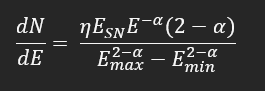

In [523]:
@u.quantity_input(E = u.erg)
def dNdE(E, Emax = 5*u.PeV, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 2.7):
    dNdE = (eta*Esn*(-alpha+2))/(Emax**(2-alpha)-Emin**(2-alpha))*E**-alpha
    return dNdE

Rshell shows the radius of the shockfront of the supernova remenant. For this model, Rshell is where the where the particles are injected into the model. This results in the distribution function being 0 for R < Rshell.
The following formula is used to find Rshell.

![Rshell formula.png](<attachment:Rshell formula.png>)

In [524]:
@u.quantity_input(t=u.yr, E=u.eV)
def Rshell(E, n0=10/u.cm**3, Esn=1e52*u.erg, Emax = 5*u.PeV, beta = 2.48):
    R = 0.31*(Esn/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(Tesc(E, Emax, beta)/u.yr)**(2/5) *u.pc
    return R.to(u.pc)

Tesc represents the time taken for the average particle at a given energy to pass the shock front of the supernova remenant. Similar to Rshell, the distribution function is 0 for T < Tesc. This can be calculated using the following formula.

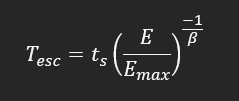

In [525]:
@u.quantity_input(E=u.erg)
def Tesc(E, Emax = 5*u.PeV, beta = 2.48, ts = 1600*u.yr):
    return (ts*(E/Emax)**(-1/beta)).to(u.yr)    

The diffudsion coefficient dictates how fast the particles will diffuse through space. This can be calculated as follows.

$$ D(E) = [0.1, 0.5] \times 10^{28} \left( \frac{E}{10 GeV} \right)^{\frac12} \left( \frac{B}{3 \mu G} \right)^{-\frac12} cm^2 s^{-1} $$

In [526]:
@u.quantity_input(E=u.erg)
def diffusion(E, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1 ):
    dif = x * Dn * ((3*E/(u.GeV)).decompose()/(10*B/(u.uG)).decompose())**delta
    return dif * u.cm**2 * u.s**-1

The distribution shows the spread of particles at any given radius greater than Rshell,any time greater then tesc and any energy. The function outputs in units of per energy per unit volume. Rdiff shows the radius of the sphere up to which the particles of energy E effectivly propogate to in time t. The distribution and Rdiff can be calculated with the following formulea.

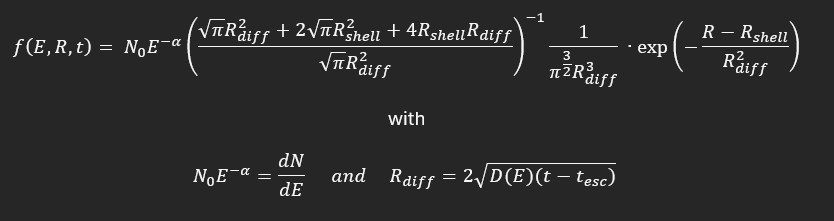

In [527]:
@u.quantity_input(E=u.erg, R=u.pc, t=u.yr, Emax=u.erg, Emin=u.erg, Esn=u.erg, B=u.G, ts=u.yr, n0=u.cm**-3)
def distribution(E, R, t, Emax = 5*u.PeV, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 2.7, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1, beta = 2.48, ts = 1600*u.yr, n0=10/u.cm**3):
    Rdif = 2 * np.sqrt(diffusion(E, B, x, delta, Dn) * (t - Tesc(E, Emax, beta, ts)))

    first1 = (np.pi**(1/2))*(Rdif**2) 
    first2 = 2*(np.pi**(1/2)*(Rshell(E, n0, Esn, Emax, beta))**2) 
    first3 = 4*Rshell(E, n0, Esn, Emax, beta)*(Rdif)
    
    firstT = first1 + first2 + first3

    dist = dNdE(E, Emax, Emin, eta, Esn, alpha)*(firstT/(np.pi**(1/2)*(Rdif)**2))**(-1)*(1/(np.pi**(3/2)*(Rdif)**3))*np.exp(-(R-Rshell(E, n0, Esn, Emax, beta))**2/(Rdif)**2)

    return dist.to(1/(u.TeV * u.cm**3))

Take input from user

In [528]:
# E_input = float(input("At what energy ? ").strip())
# if(E_input == 0):
#     E_input = 5*u.TeV
E_input = 5*u.TeV

# T_input = float(input("At what time ? ").strip())
# if(T_input == 0):
#     T_input = 50*u.kyr
T_input = 50*u.kyr

# R_input = float(input("At what radius ? ").strip())
# if(R_input == 0):
#     R_input = 50*u.pc
R_input = 50*u.pc

Plotting against R

Text(0.5, 1.0, 'Particle distribution against radius')

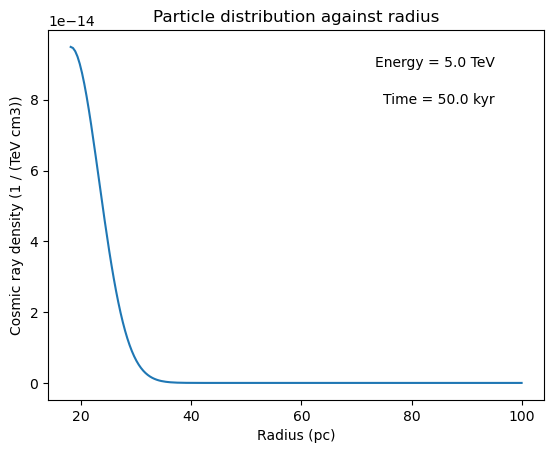

In [529]:
Rs = np.linspace(Rshell(E_input), 100*u.pc, 200)

plt.plot(Rs, distribution(E_input, Rs, T_input))

plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E_input, Rs, T_input).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius")


Plotting against t

Text(0.5, 1.0, 'Particle distribution against time')

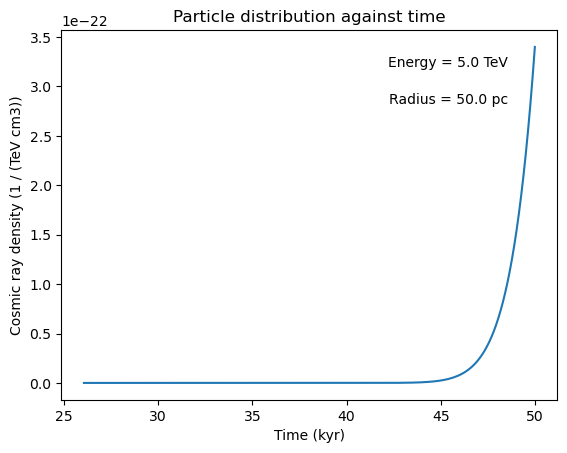

In [530]:
ts = np.linspace(Tesc(E_input).to(u.kyr).value, (50*u.kyr).to(u.kyr).value, 200)*u.kyr


plt.plot(ts, distribution(E_input, R_input, ts))

plt.xlabel(f"Time ({ts.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E_input, R_input, ts).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against time")


#plt.yscale("log")

Plotting against E

Text(0.5, 1.0, 'Particle distribution against energy')

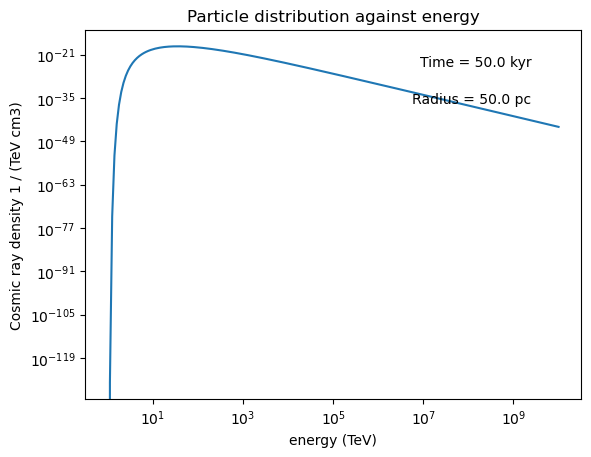

In [531]:
Es = np.logspace(0, 10, 200)*u.TeV

plt.plot(Es, distribution(Es, R_input, T_input))
plt.yscale("log")
plt.xscale("log")

plt.xlabel(f"energy ({Es.unit})")
plt.ylabel(f"Cosmic ray density {distribution([E_input]*u.TeV, R_input, T).unit}")
plt.text(0.9, 0.9, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")


## Any further plots can be made below for hard coded t, R and E. Existing linspaces of ts, Rs and logspace Es can be used, or new ones made

In [532]:
a = np.linspace(1, 10)
mask = a > 5
a[mask]

array([ 5.04081633,  5.2244898 ,  5.40816327,  5.59183673,  5.7755102 ,
        5.95918367,  6.14285714,  6.32653061,  6.51020408,  6.69387755,
        6.87755102,  7.06122449,  7.24489796,  7.42857143,  7.6122449 ,
        7.79591837,  7.97959184,  8.16326531,  8.34693878,  8.53061224,
        8.71428571,  8.89795918,  9.08163265,  9.26530612,  9.44897959,
        9.63265306,  9.81632653, 10.        ])

Plotting against energy as time progresses

Text(0.5, 1.0, 'Particle distribution against energy')

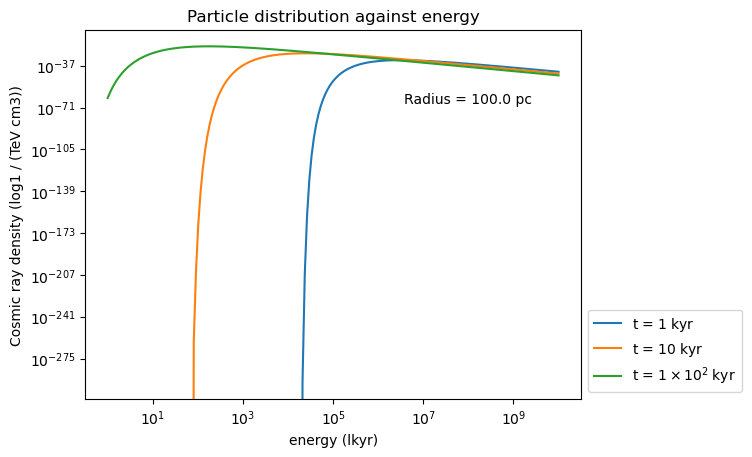

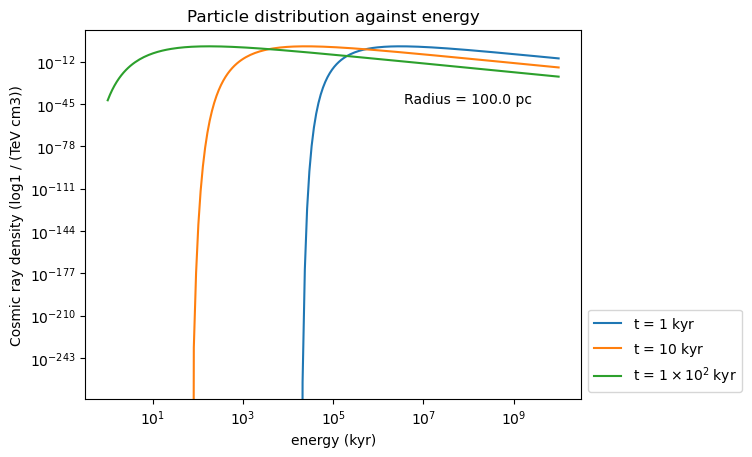

In [533]:
Es = np.logspace(0, 10, 200)*u.TeV
R = 100*u.pc
T = [1, 10, 100] *u.kyr


plt.figure()
for i in T:
    plt.plot(Es, distribution(Es, R, i), label=f"t = {i.to_string(format='latex', precision=2)}")
plt.yscale("log")
plt.xscale("log")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"energy (l{ts.unit})")
plt.ylabel(f"Cosmic ray density (log{distribution(Es[0], R, T).unit})")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")

plt.figure()
for i in T:
    plt.plot(Es, distribution(Es, R, i)/np.nanmax(distribution(Es, R, i)), label=f"t = {i.to_string(format='latex', precision=2)}")
plt.yscale("log")
plt.xscale("log")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"energy ({ts.unit})")
plt.ylabel(f"Cosmic ray density (log{distribution(Es[0], R, T).unit})")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")

Plotting radius as time progresses

Text(0.5, 1.0, 'Particle distribution against radius')

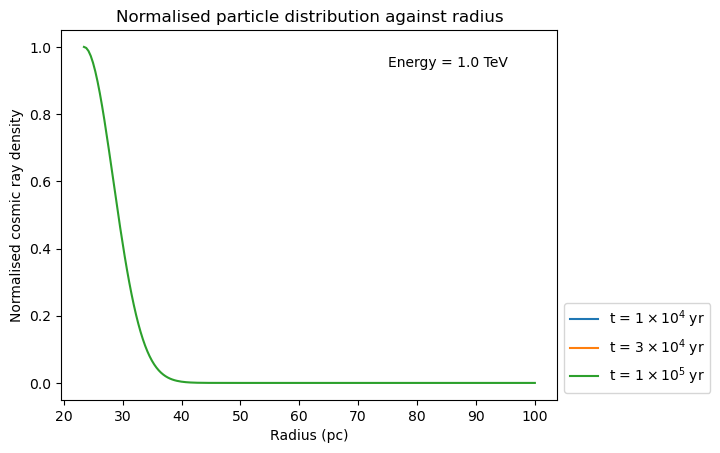

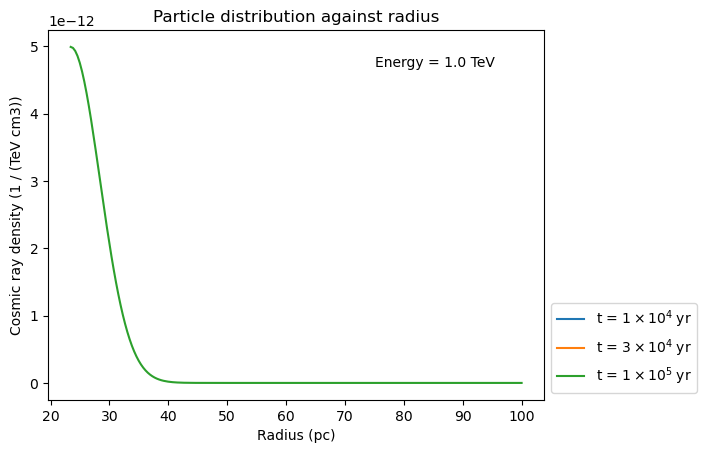

In [534]:
E = 1 * u.TeV
Rs = np.linspace(Rshell(E), 100*u.pc, 200)

T = [1e4, 3e4, 10e4] * u.yr

plt.figure()

for i in T:
    plt.plot(Rs, distribution(E, Rs, i)/np.max(distribution(E, Rs, i)), label=f"t = {i.to_string(format='latex', precision=2)}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Normalised cosmic ray density")
plt.text(0.9, 0.9, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Normalised particle distribution against radius")

plt.figure()

for i in T:
    plt.plot(Rs, distribution(E, Rs, i), label=f"t = {i.to_string(format='latex', precision=2)}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E, Rs[0], T).unit})")
plt.text(0.9, 0.9, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius")

plot function for variables

In [535]:

@u.quantity_input(E=u.erg, R=u.pc, t=u.yr,)
def plotVar(xaxis, perameter, variablespace, perameter_name, t = 1e4 * u.yr, E = 100 * u.TeV, R = 50 * u.pc, logx = False, logy = False):

    Rs = np.linspace(Rshell(E), 100 * u.pc, 200)     # n0=10/u.cm**3, Esn=1e52*u.erg, Emax = 5*u.PeV, beta = 2.48
    Es = np.logspace(0, 10, 200) * u.TeV
    ts = np.linspace(Tesc(E).to(u.kyr).value, (50 * u.kyr).to(u.kyr).value, 200)*u.kyr    # Emax = 5*u.PeV, beta = 2.48, ts = 1600*u.yr

    # Choose axis based on xaxis variable
    if xaxis == 'R':
        axis = Rs
        R = Rs  # Update R to match axis
        xaxis_label = 'Radius'
    elif xaxis == 'E':
        logx = True
        logy = True
        axis = Es
        E = Es  # Update E to match axis
        xaxis_label = 'Energy'
    elif xaxis == 't':
        axis = ts
        t = ts  # Update t to match the axis
        xaxis_label = 'Time'
    else:
        raise ValueError("xaxis should be one of 'R', 'E', or 't'.")
    plt.figure()

    for i in variablespace:
        kwargs = {perameter_name: i}

        if perameter_name == 'n0' or perameter_name == 'Esn' or perameter_name == 'Emax' or perameter_name == 'beta':
            Rs = np.linspace(Rshell(E, **kwargs), 100 * u.pc, 200)
        elif perameter_name == 'Emax' or perameter_name == 'beta' or perameter_name == 'ts':
            ts = np.linspace(Tesc(E, **kwargs).to(u.kyr).value, (50 * u.kyr).to(u.kyr).value, 200)*u.kyr

        dist = distribution(E, R, t, **kwargs)
        plt.plot(axis, dist / np.nanmax(dist), label=f"{perameter_name} = {i}")

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.xlabel(f"{xaxis_label} ({axis.unit})")
    plt.ylabel(f"Normalised cosmic ray density ({distribution(E, R, t).unit})")
    plt.title(f"Normalised particle distribution against {xaxis_label} with varying {perameter_name}")

    if xaxis == 'R':
        plt.text(0.9, 0.9, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 'E':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 't':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")

    if(logx == True):
        plt.xscale("log")
    if logy == True:
        plt.yscale("log")
        

    plt.figure()

    for i in variablespace:
        kwargs = {perameter_name: i}

        if perameter_name == 'n0' or perameter_name == 'Esn' or perameter_name == 'Emax' or perameter_name == 'beta':
            Rs = np.linspace(Rshell(E, **kwargs), 100 * u.pc, 200)
        elif perameter_name == 'Emax' or perameter_name == 'beta' or perameter_name == 'ts':
            ts = np.linspace(Tesc(E, **kwargs).to(u.kyr).value, (50 * u.kyr).to(u.kyr).value, 200)*u.kyr

        dist = distribution(E, R, t, **kwargs)
        plt.plot(dist, label=f"{perameter_name} = {i}")

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.xlabel(f"{xaxis_label} ({axis.unit})")
    plt.ylabel(f"Cosmic ray density ({distribution(E, R, t).unit})")
    plt.title(f"Particle distribution against {xaxis_label} with varying {perameter_name}")
    if xaxis == 'R':
        plt.text(0.9, 0.9, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 'E':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 't':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")

    if(logx == True):
        plt.xscale("log")
    if logy == True:
        plt.yscale("log")


Alpha var

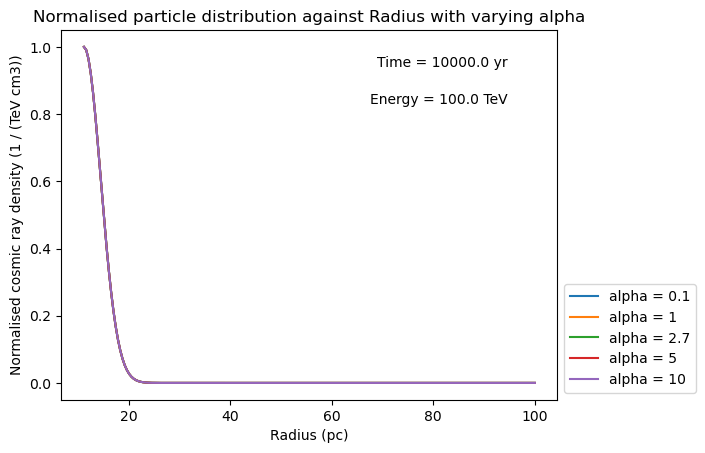

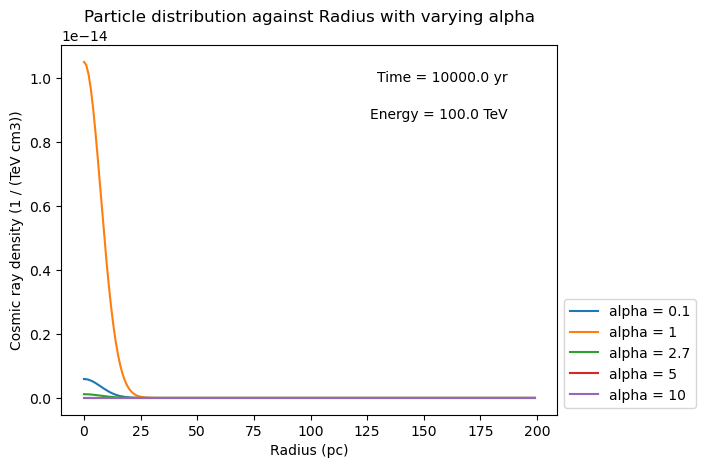

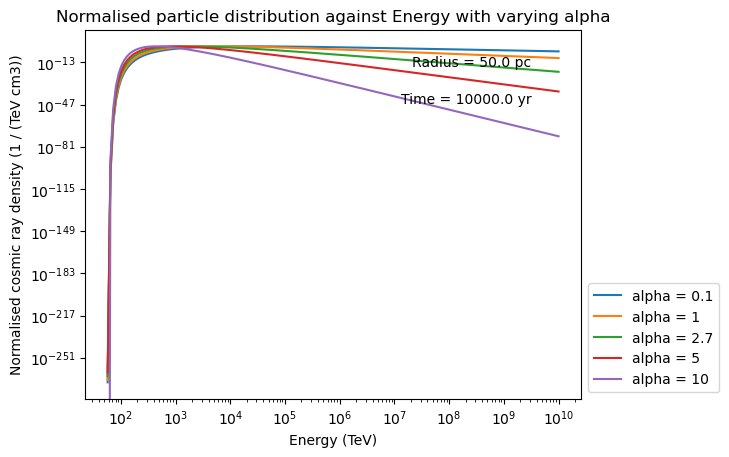

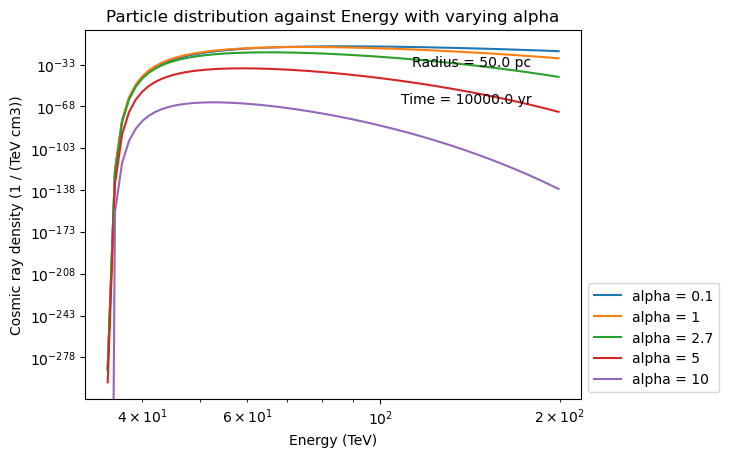

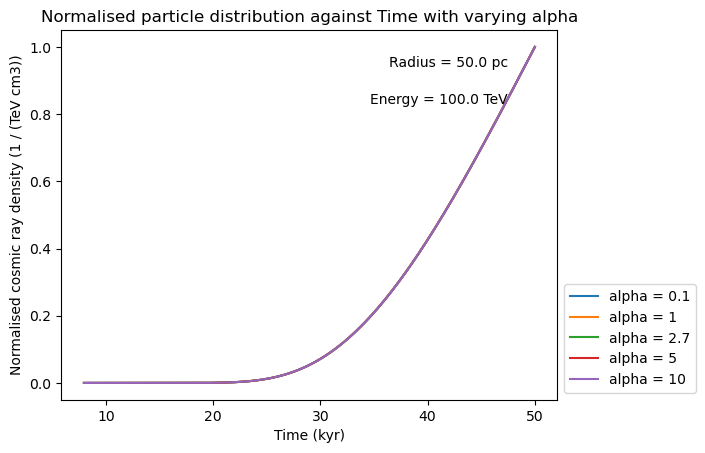

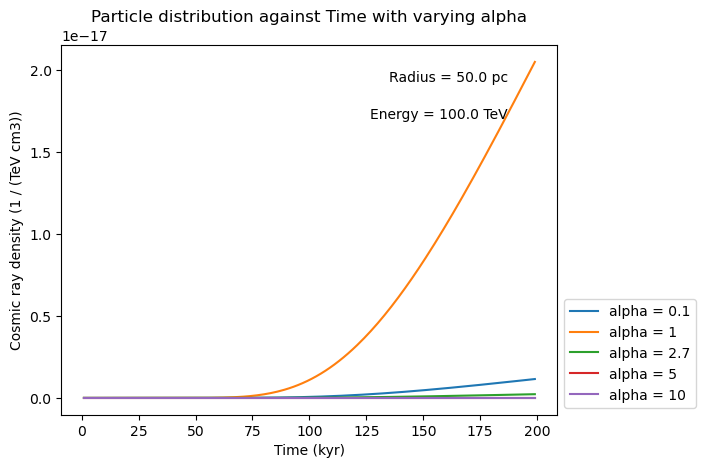

In [536]:
alpha = 3
arr = [0.1, 1, 2.7, 5, 10]

plotVar('R', alpha, arr, 'alpha')
plotVar('E', alpha, arr, 'alpha')
plotVar('t', alpha, arr, 'alpha')


Varying Esn

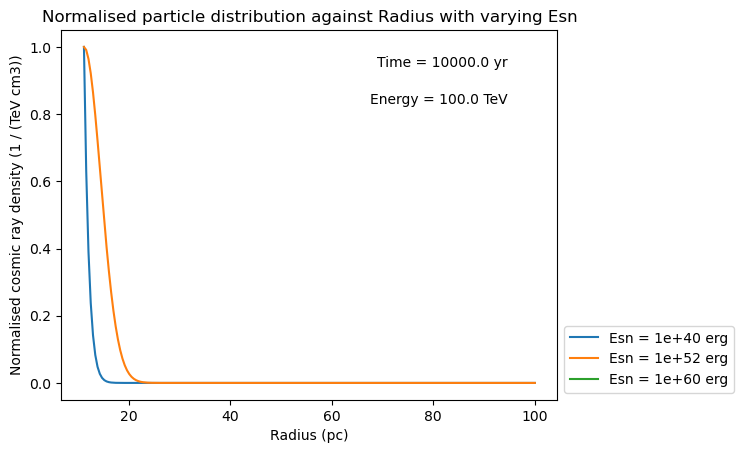

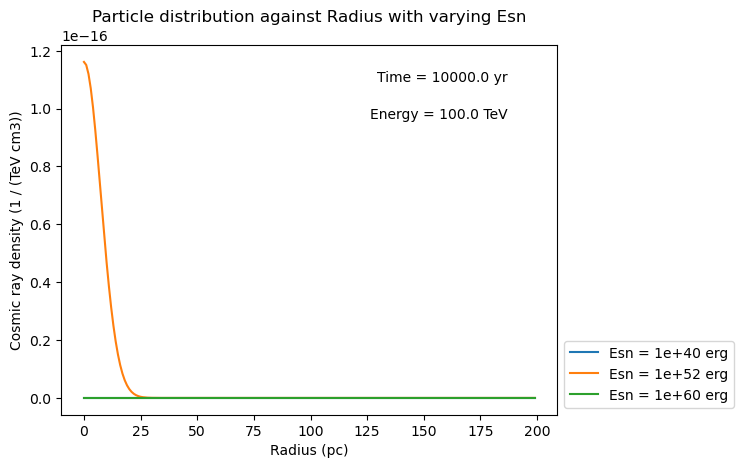

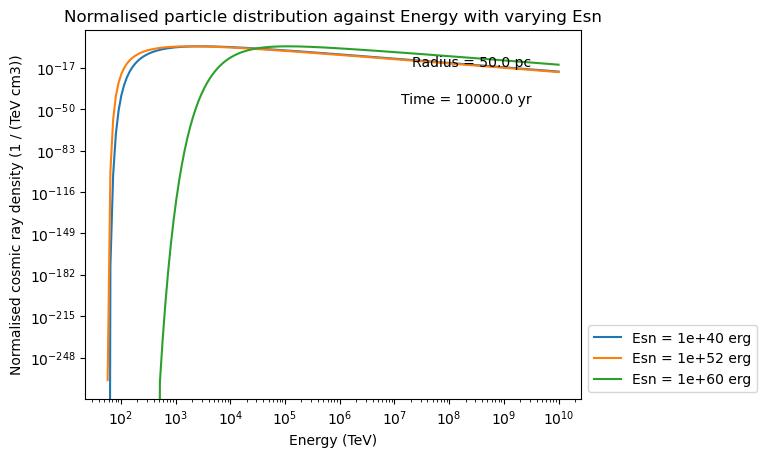

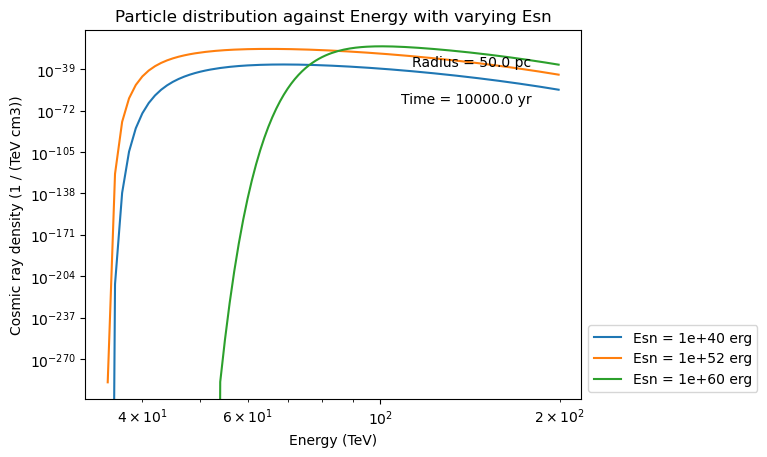

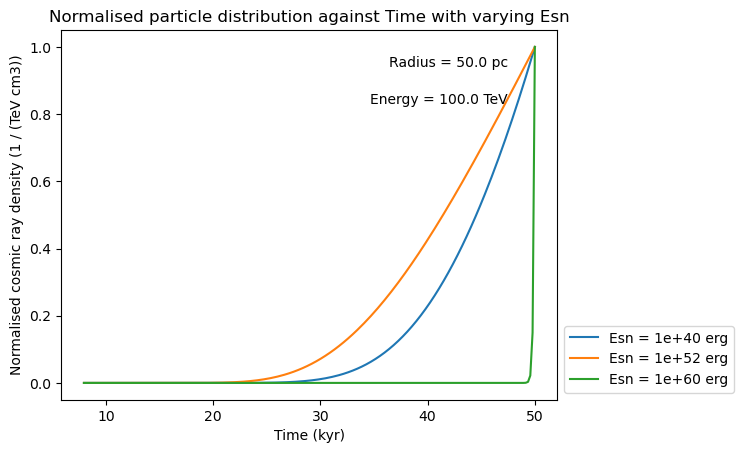

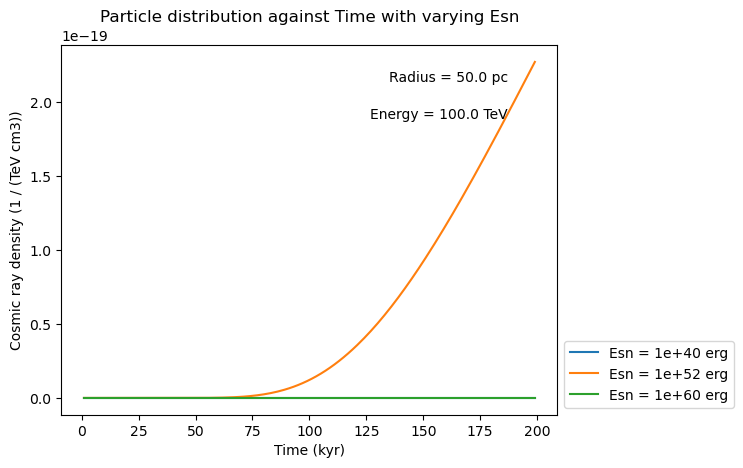

In [537]:
Esn = 3
arr = [1e40, 1e52, 1e60]*u.erg

plotVar('R', Esn, arr, 'Esn')
plotVar('E', Esn, arr, 'Esn')
plotVar('t', Esn, arr, 'Esn')

Varying Emax

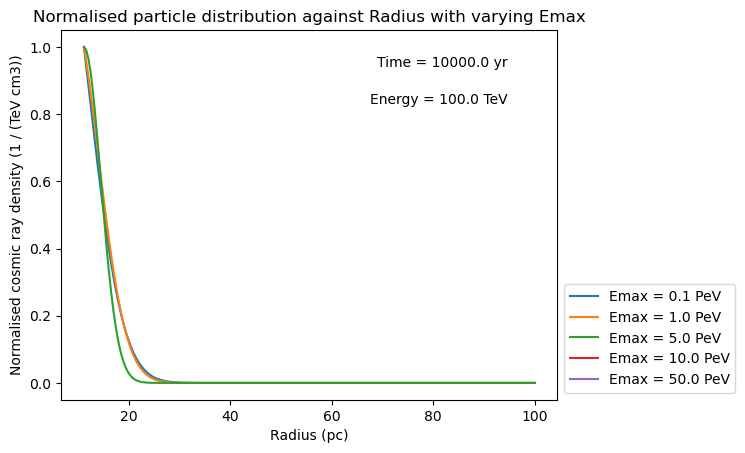

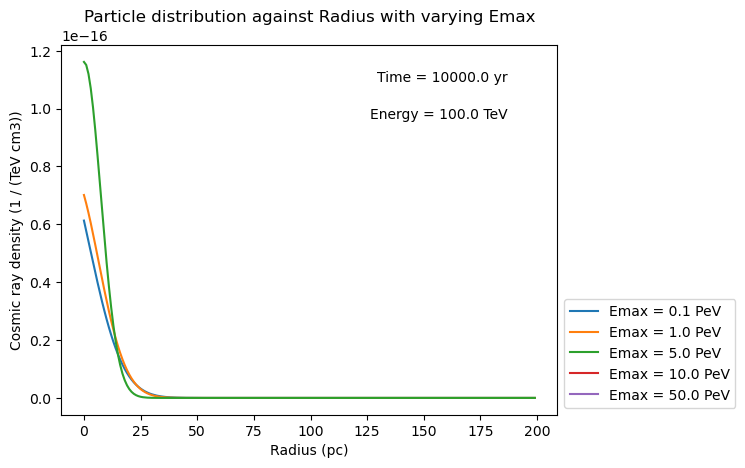

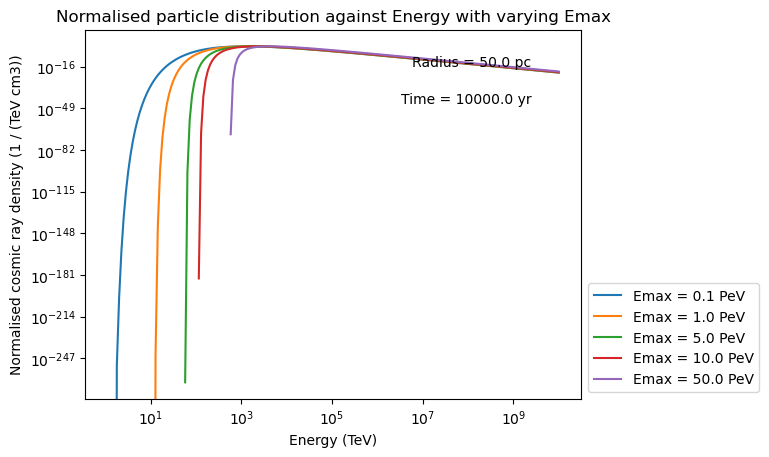

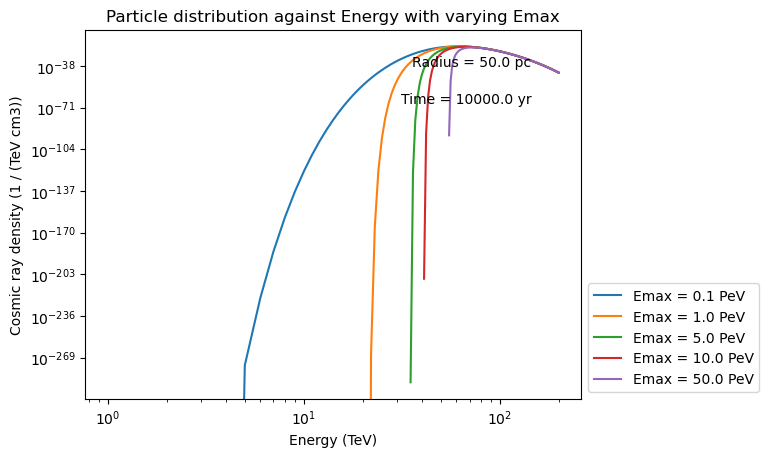

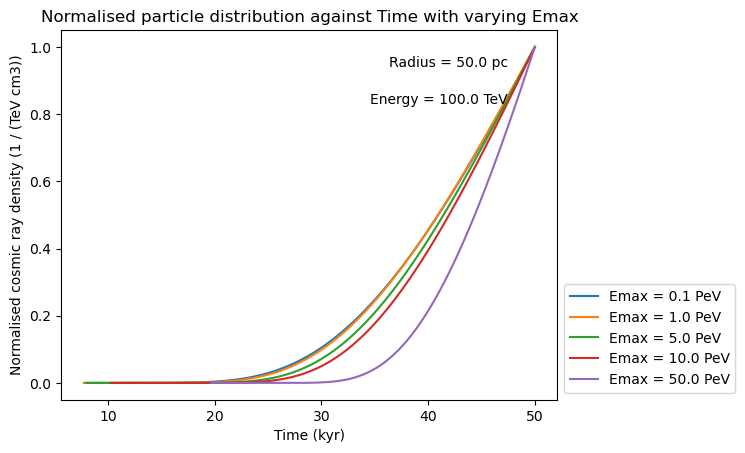

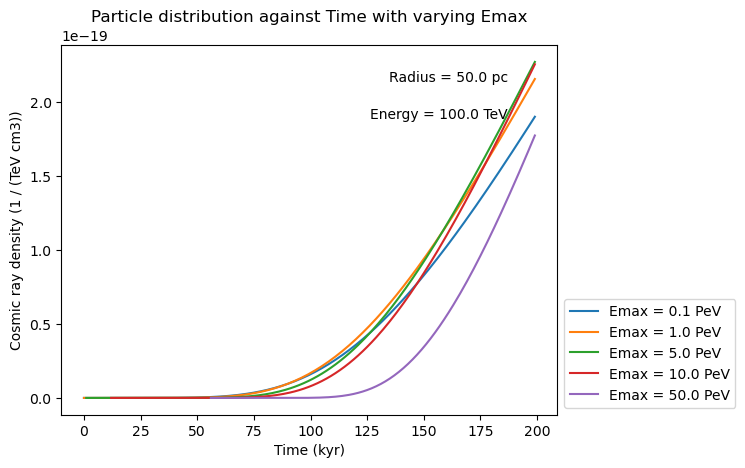

In [538]:
Emax = 3
arr = [0.1, 1, 5, 10, 50]*u.PeV

plotVar('R', Emax, arr, 'Emax')
plotVar('E', Emax, arr, 'Emax')
plotVar('t', Emax, arr, 'Emax')

Varying Emin

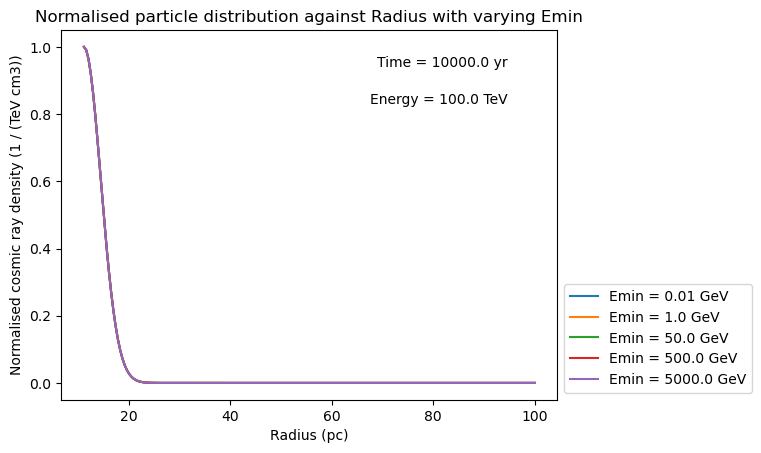

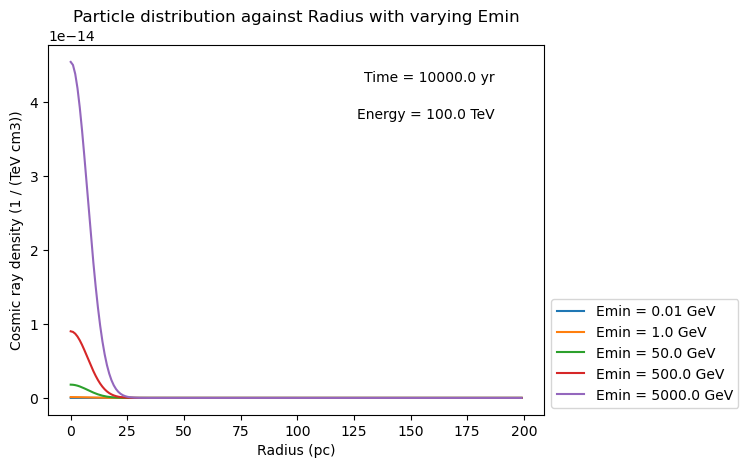

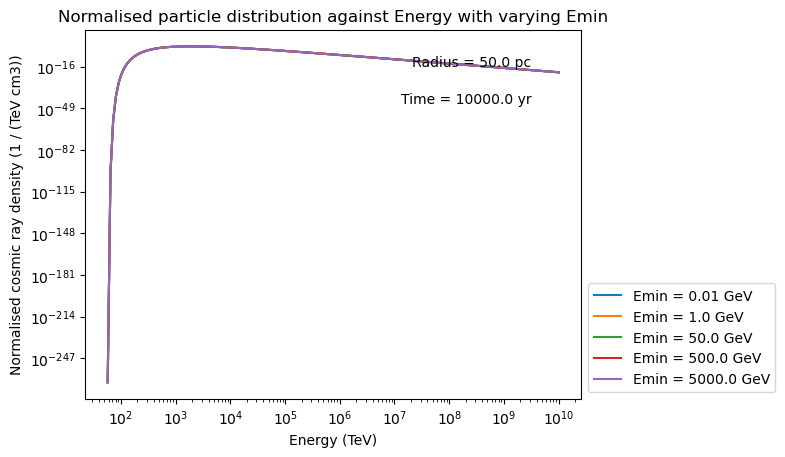

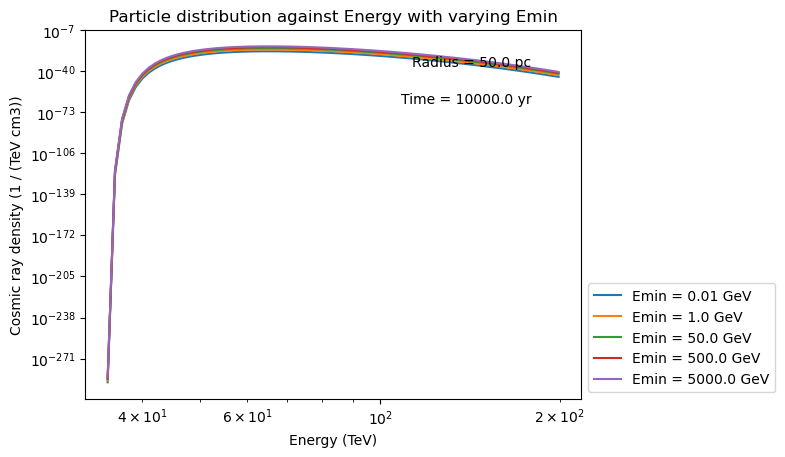

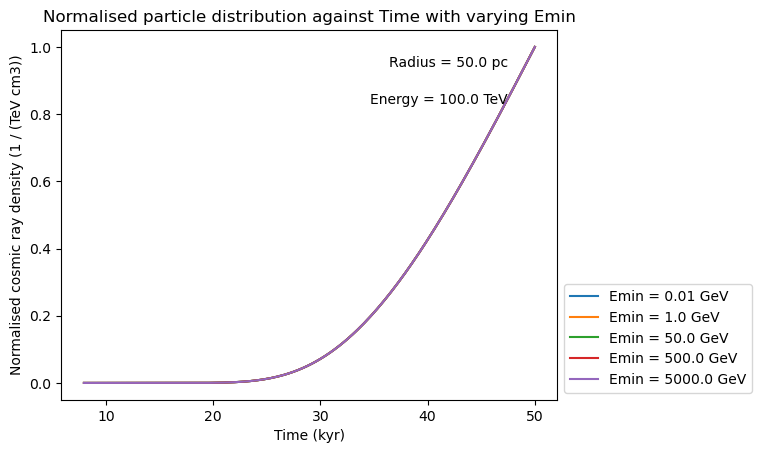

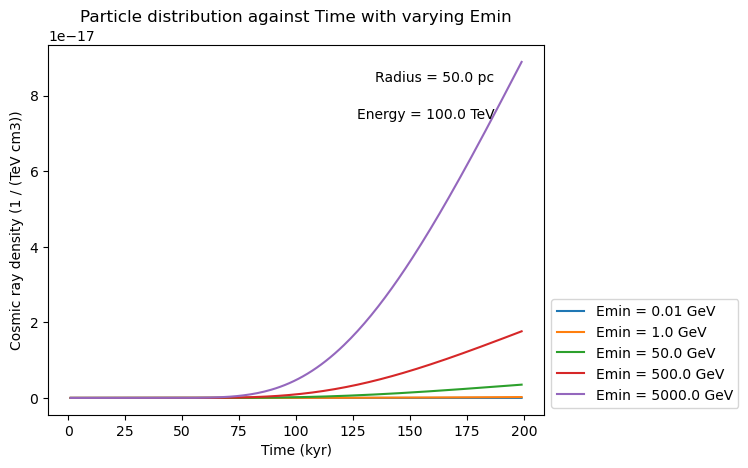

In [539]:
Emin = 3
arr = [0.01, 1, 50, 500, 5000]*u.GeV

plotVar('R', Emin, arr, 'Emin')
plotVar('E', Emin, arr, 'Emin')
plotVar('t', Emin, arr, 'Emin')

Varying eta

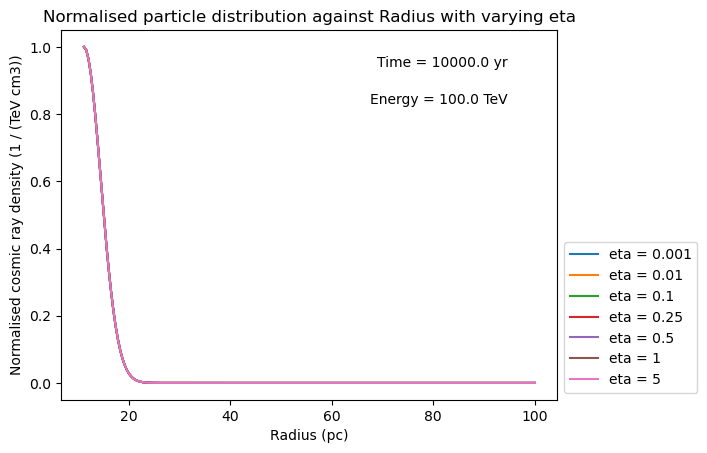

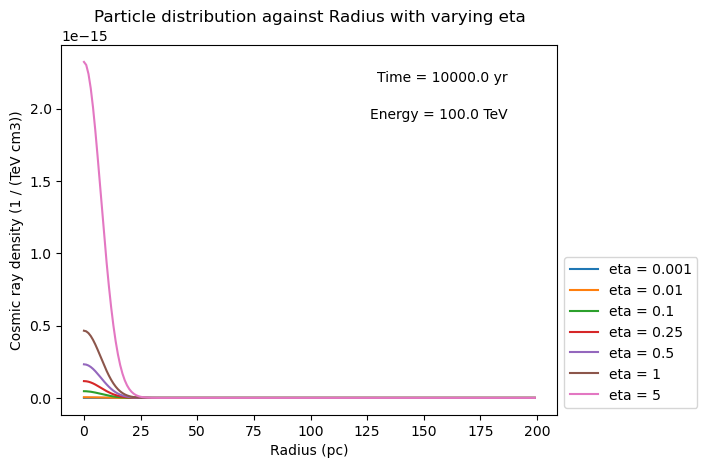

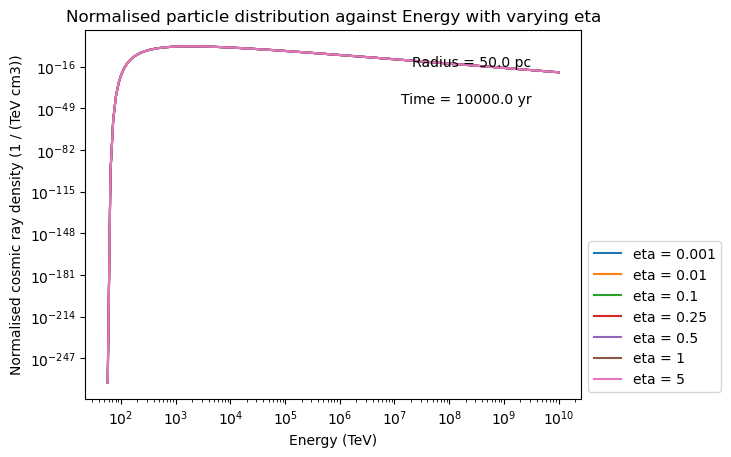

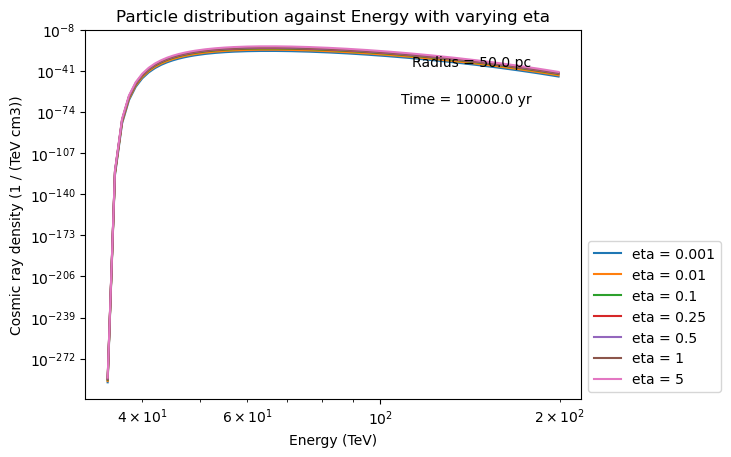

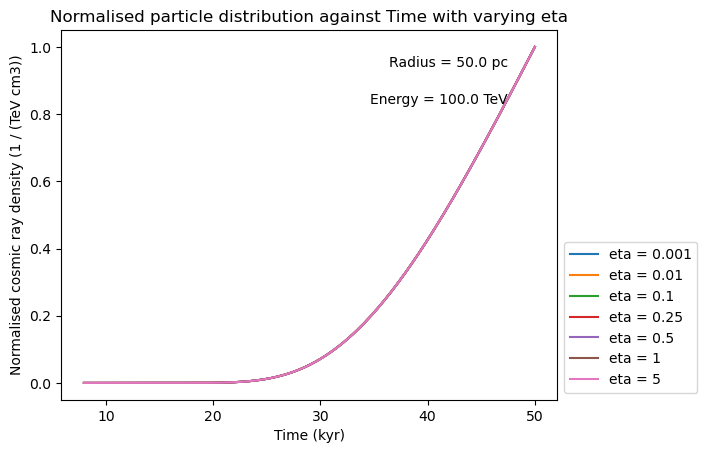

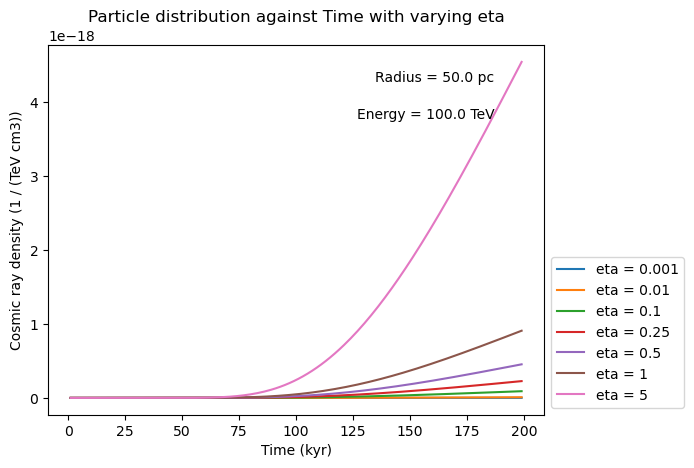

In [540]:
eta = 3
arr = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 5]

plotVar('R', eta, arr, 'eta')
plotVar('E', eta, arr, 'eta')
plotVar('t', eta, arr, 'eta')

Varying B

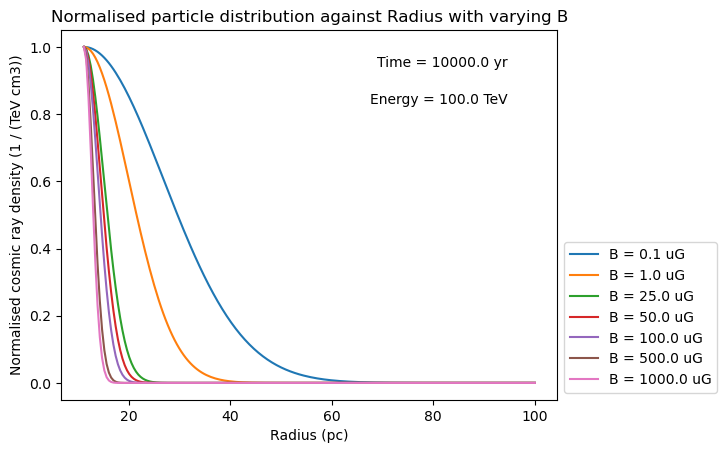

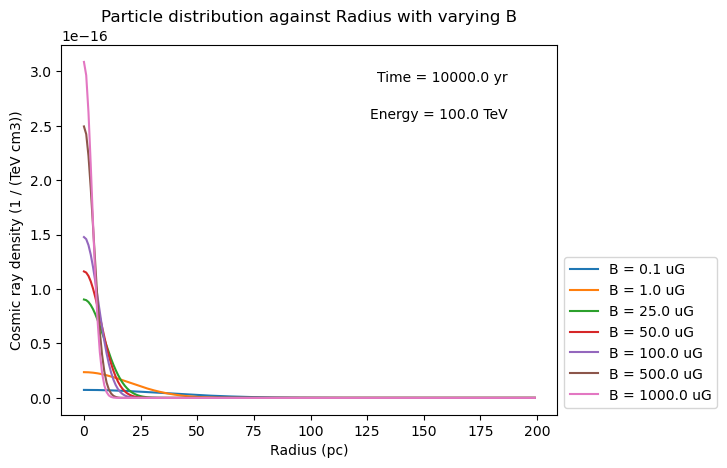

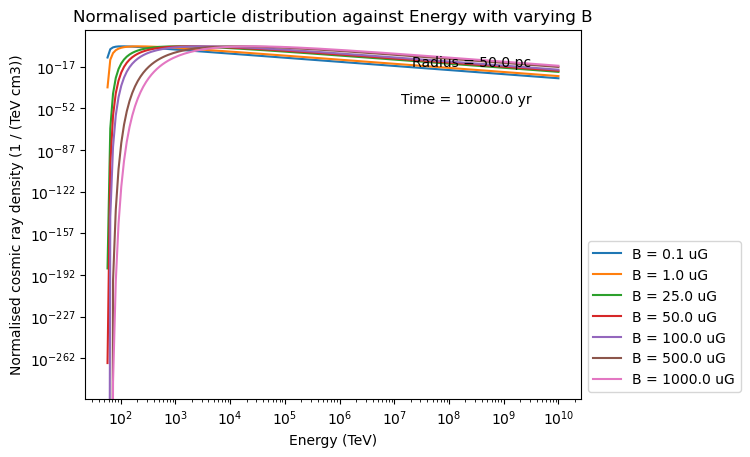

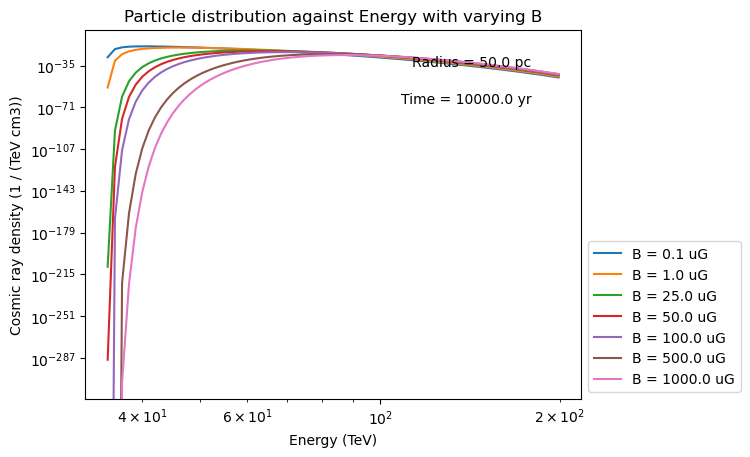

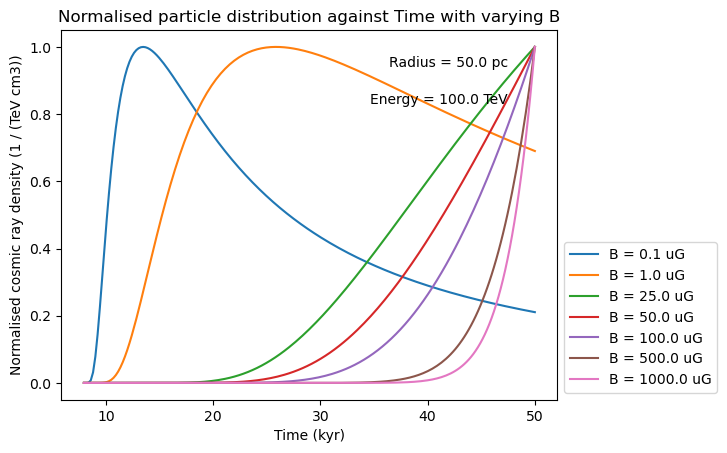

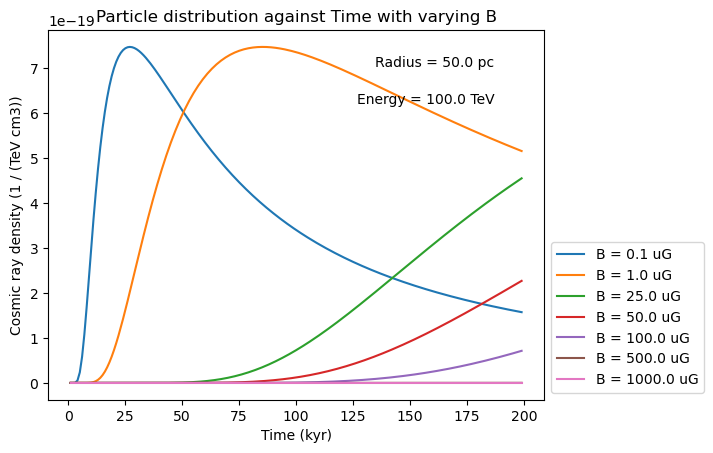

In [541]:
B = 3
arr = [0.1, 1, 25, 50, 100, 500, 1000]*u.uG

plotVar('R', B, arr, 'B')
plotVar('E', B, arr, 'B')
plotVar('t', B, arr, 'B')

Varying x

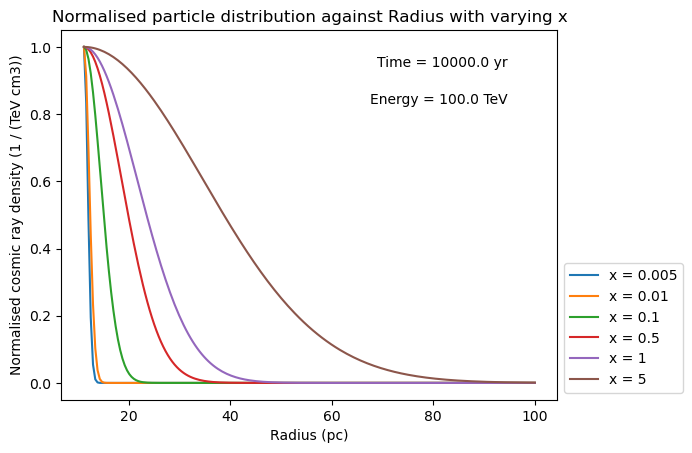

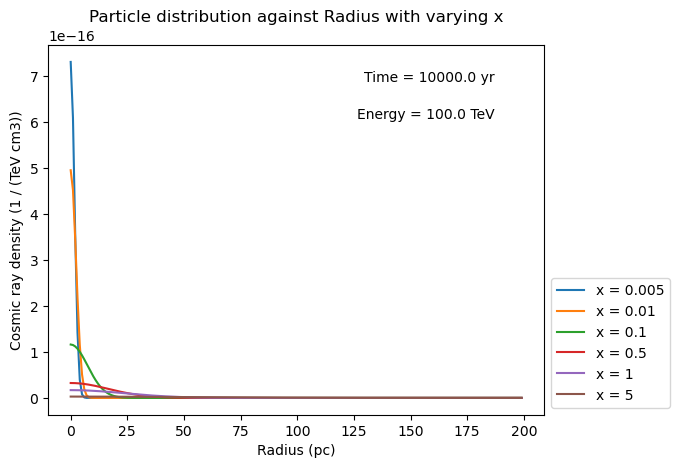

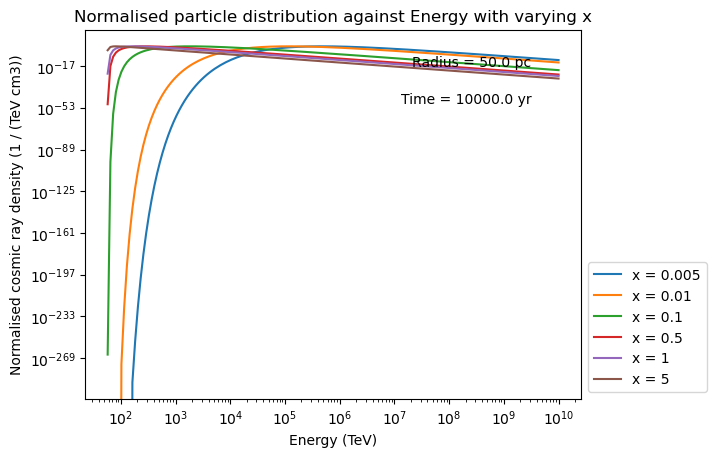

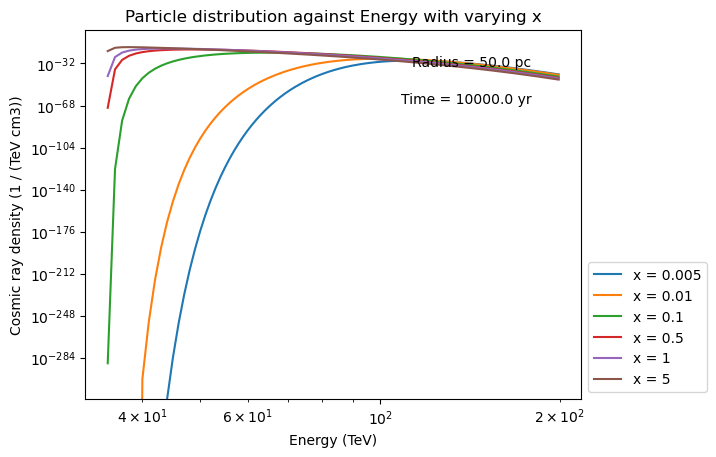

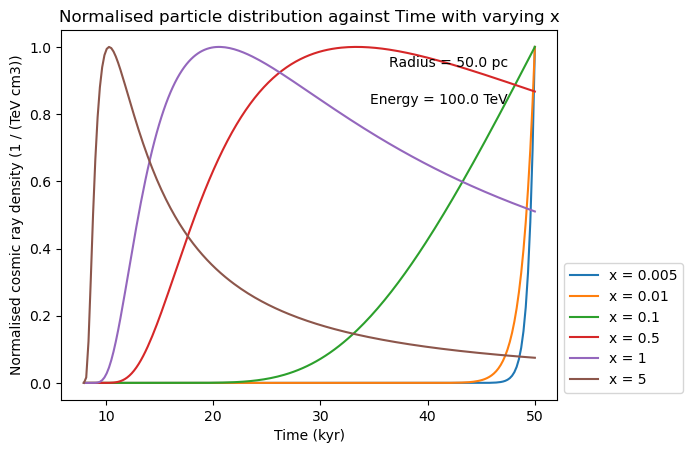

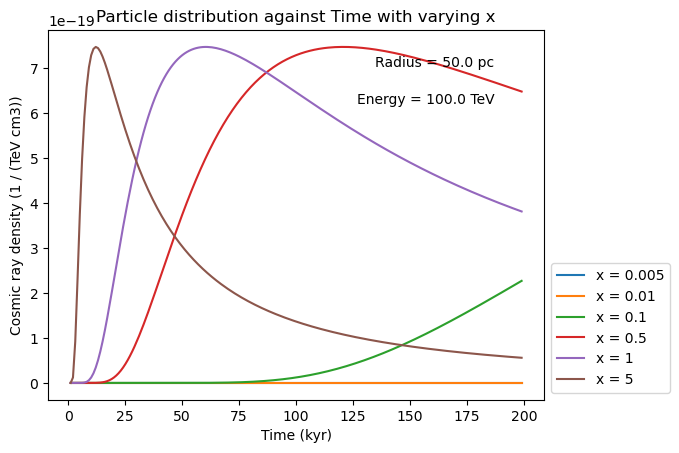

In [542]:
x = 0
arr = [0.005, 0.01, 0.1, 0.5, 1, 5]

plotVar('R', x, arr, 'x')
plotVar('E', x, arr, 'x')
plotVar('t', x, arr, 'x')

varying delta

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


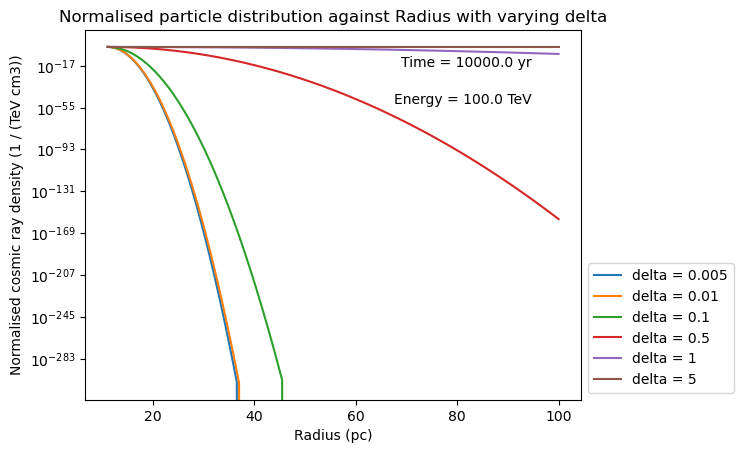

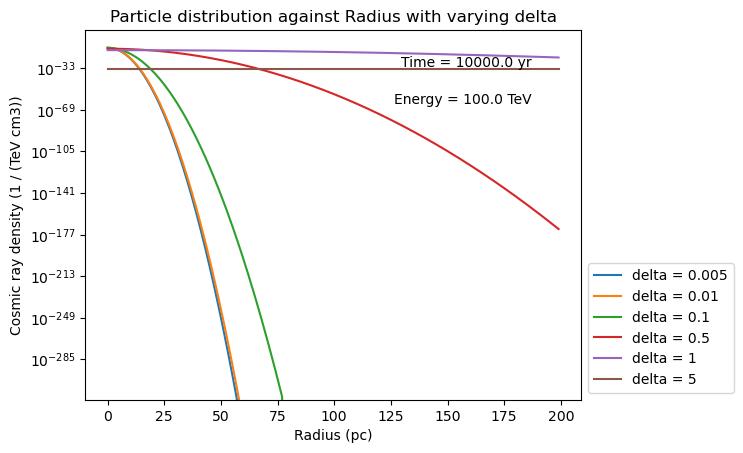

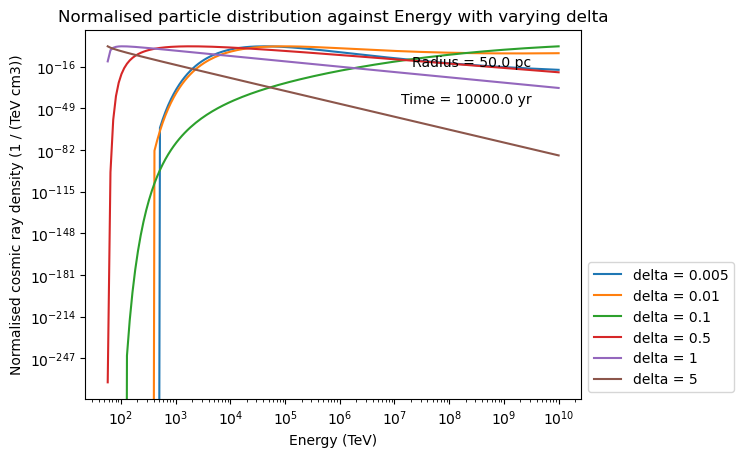

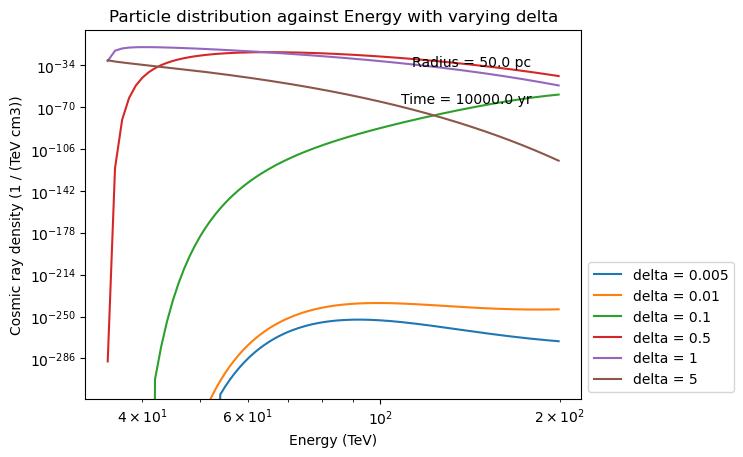

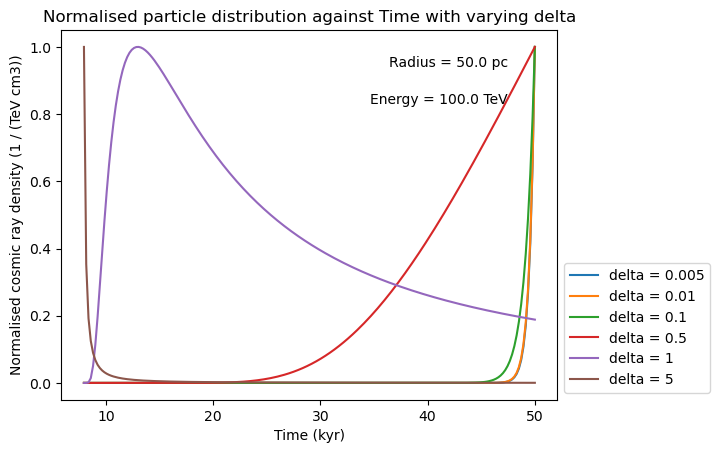

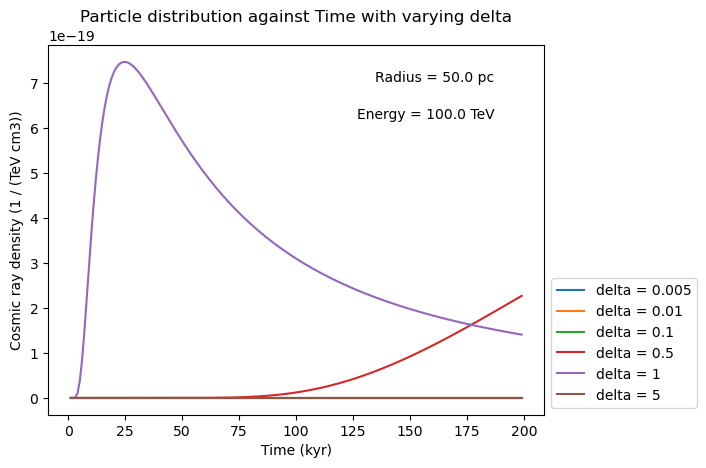

In [548]:
delta = 3
arr = [0.005, 0.01, 0.1, 0.5, 1, 5]

plotVar('R', delta, arr, 'delta', logy = True)
plotVar('E', delta, arr, 'delta')
plotVar('t', delta, arr, 'delta')

VArying Dn

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


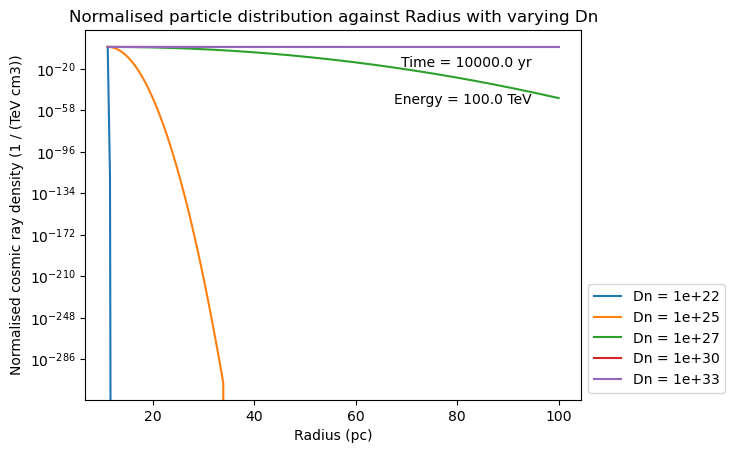

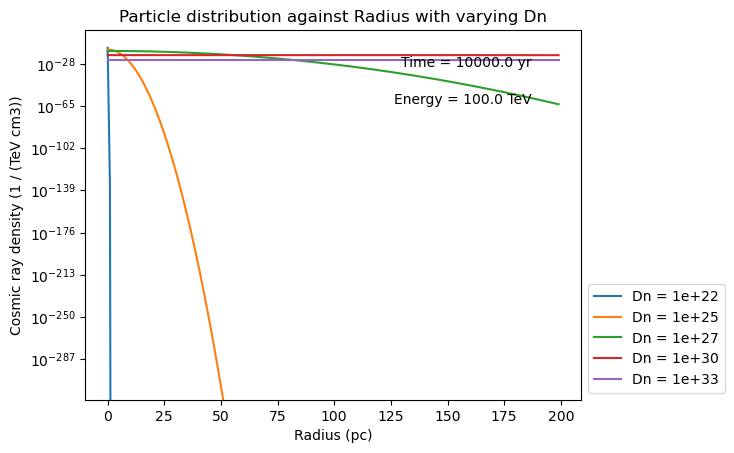

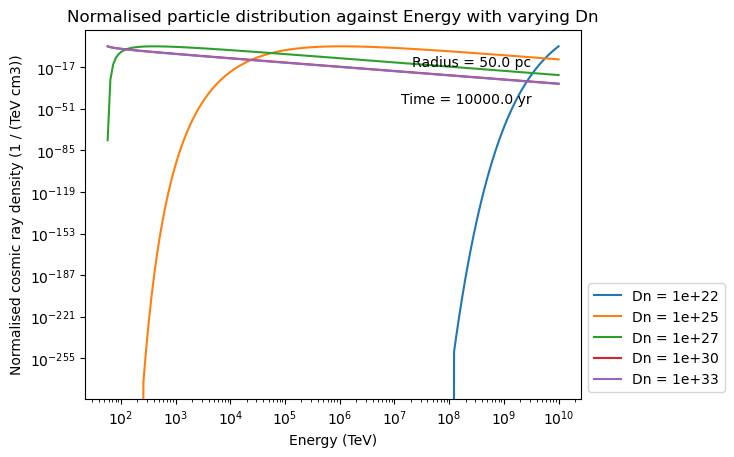

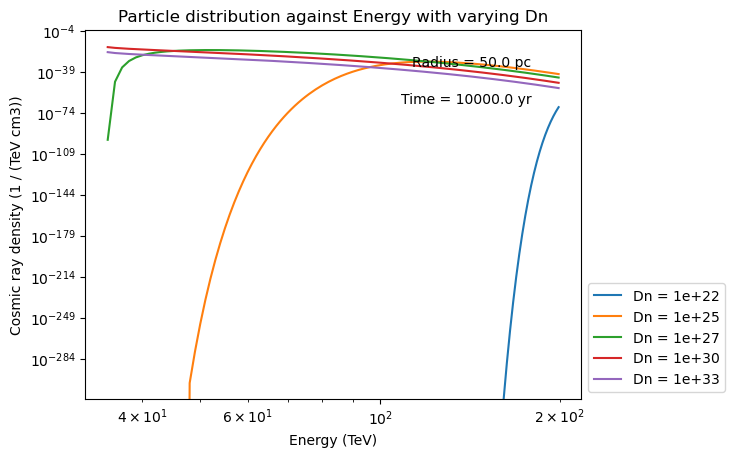

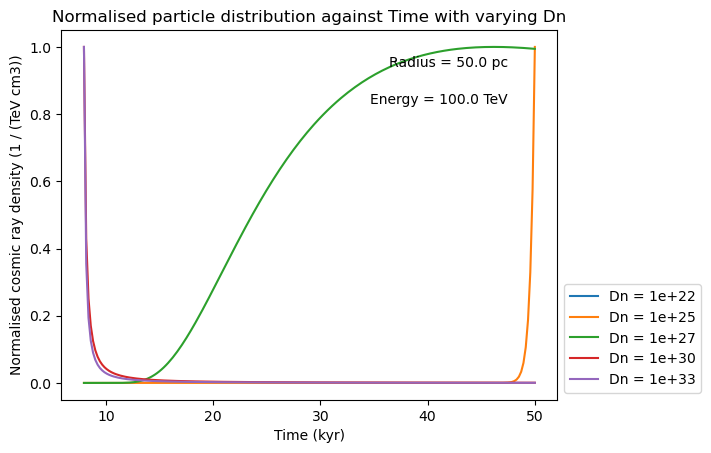

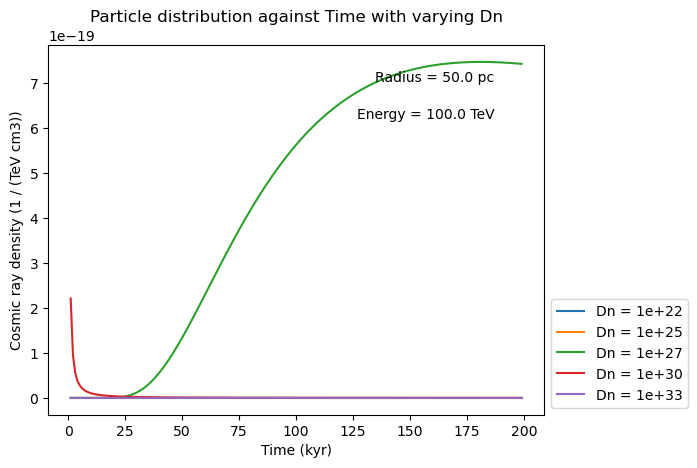

In [553]:
Dn = 3
arr = [1e22, 1e25, 1e27, 1e30, 1e33]

plotVar('R', Dn, arr, 'Dn', logy = True)
plotVar('E', Dn, arr, 'Dn')
plotVar('t', Dn, arr, 'Dn')

Varying ts

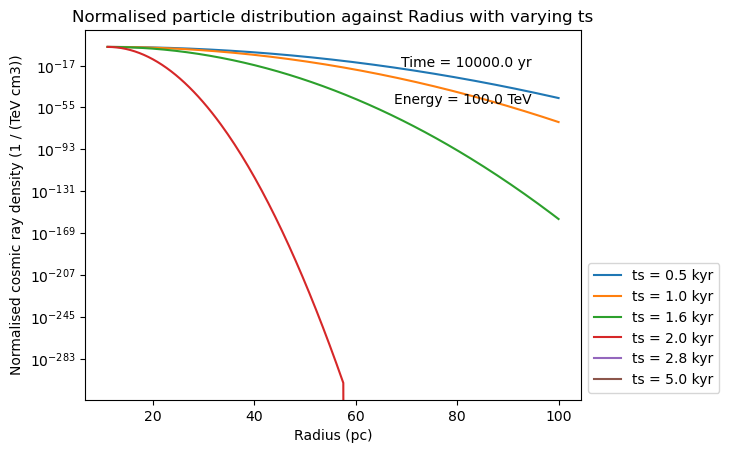

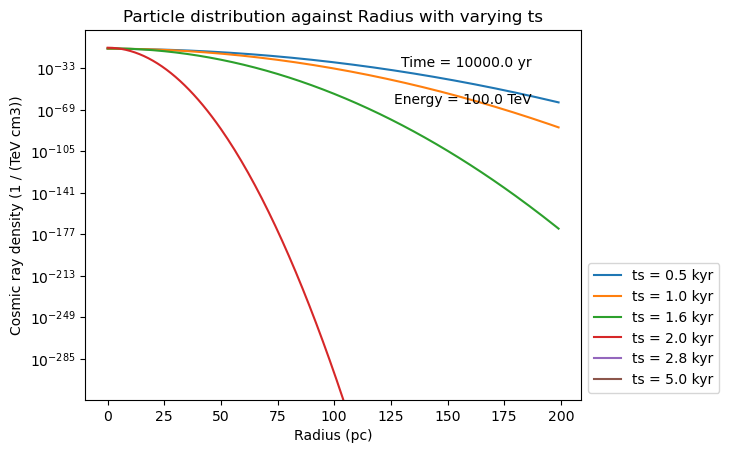

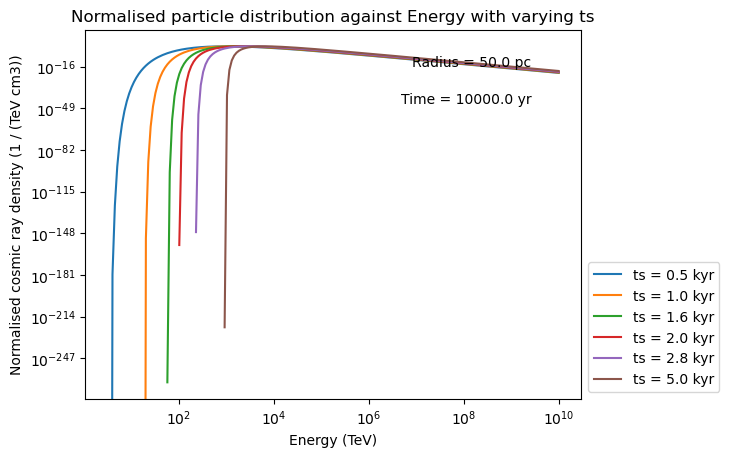

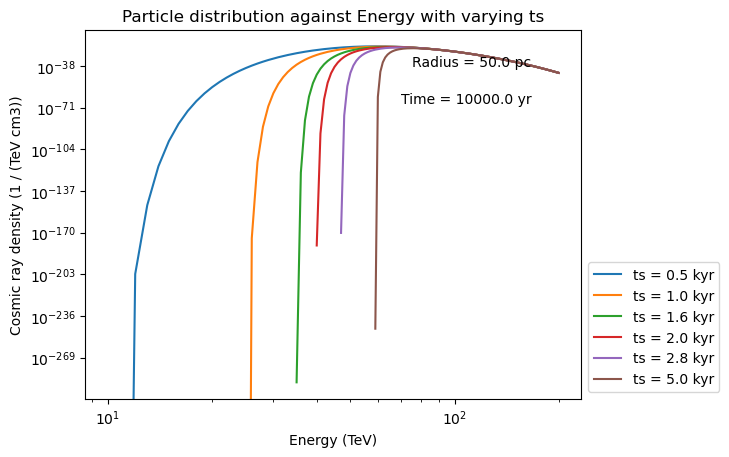

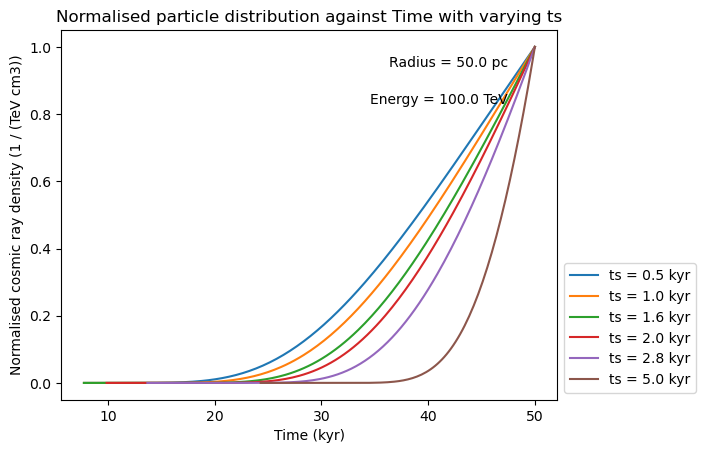

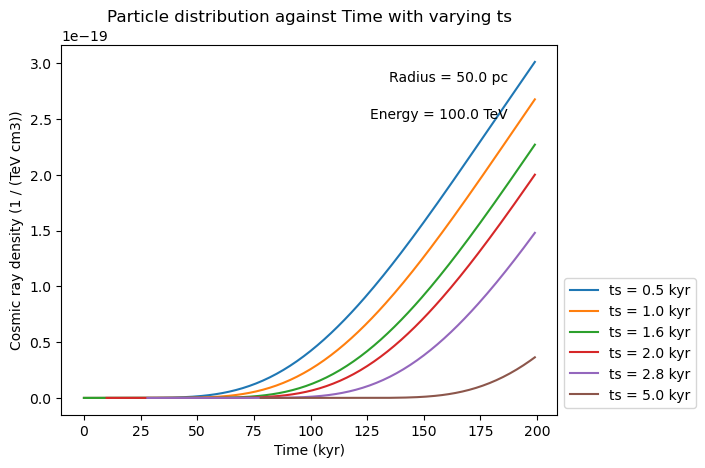

In [563]:
ts = 3
arr = [0.5, 1, 1.6, 2, 2.8, 5]*u.kyr

plotVar('R', ts, arr, 'ts', logy = True)
plotVar('E', ts, arr, 'ts')
plotVar('t', ts, arr, 'ts')

varying n0

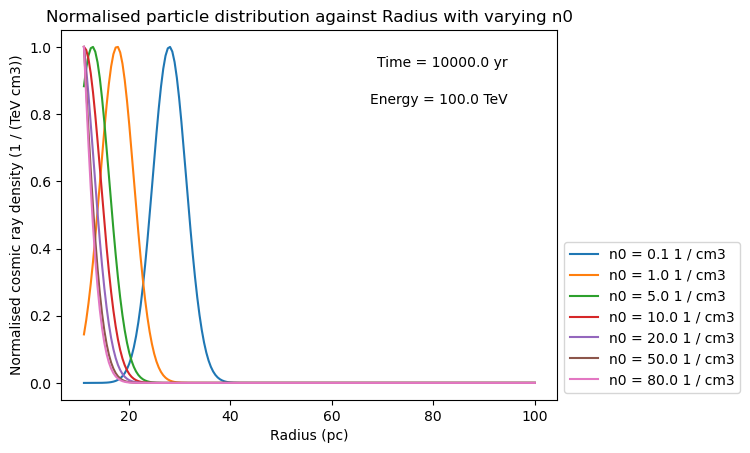

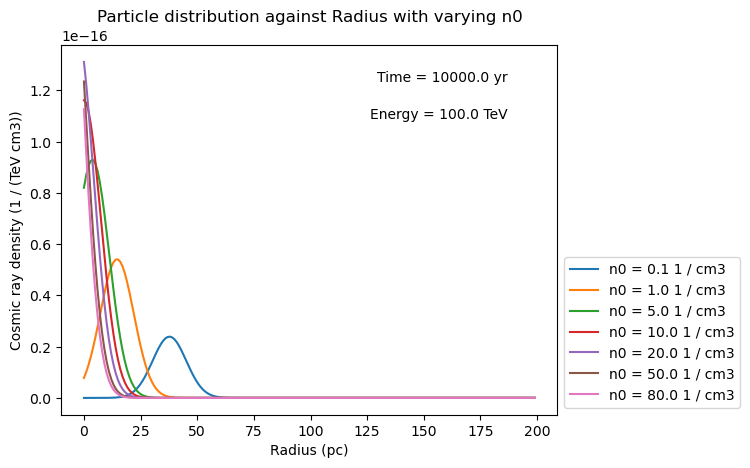

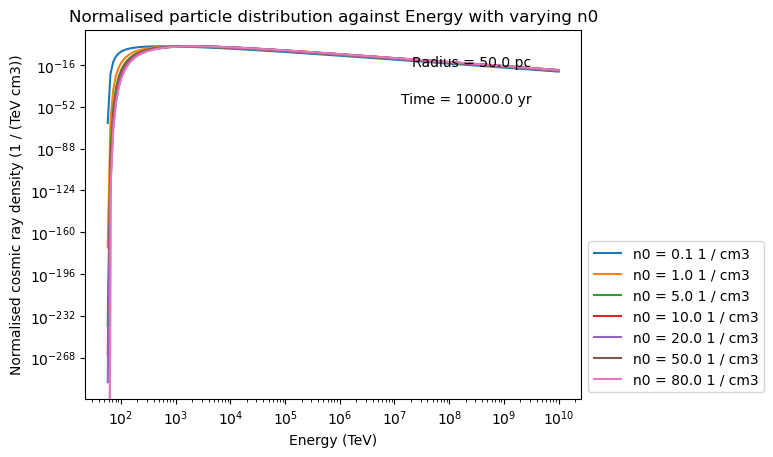

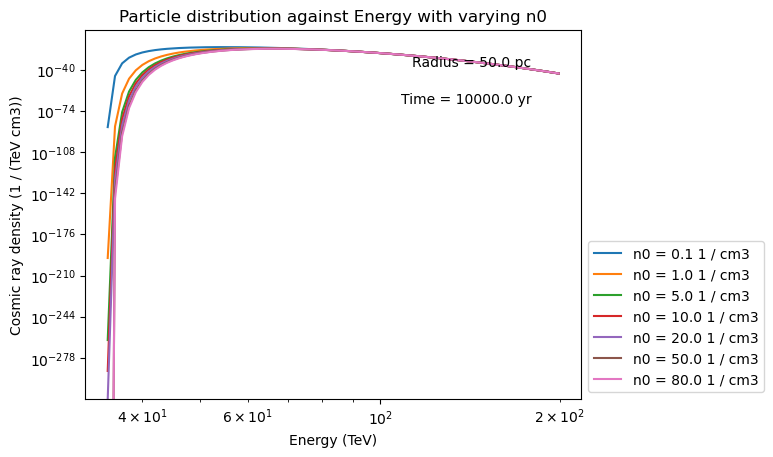

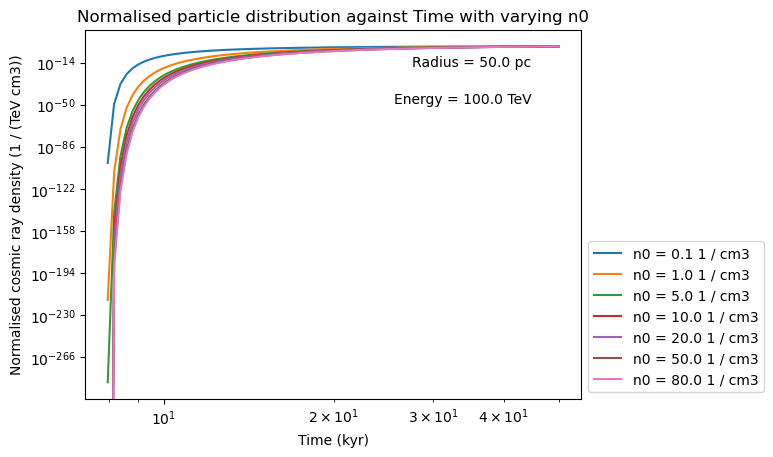

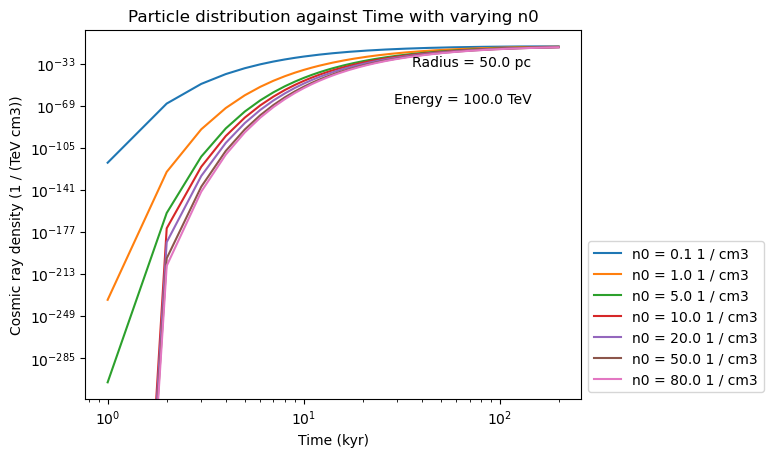

In [564]:
n0 = 3
arr = [0.1, 1, 5, 10, 20, 50, 80]/u.cm**3

plotVar('R', n0, arr, 'n0')
plotVar('E', n0, arr, 'n0')
plotVar('t', n0, arr, 'n0', logx = True, logy = True)

Beta var

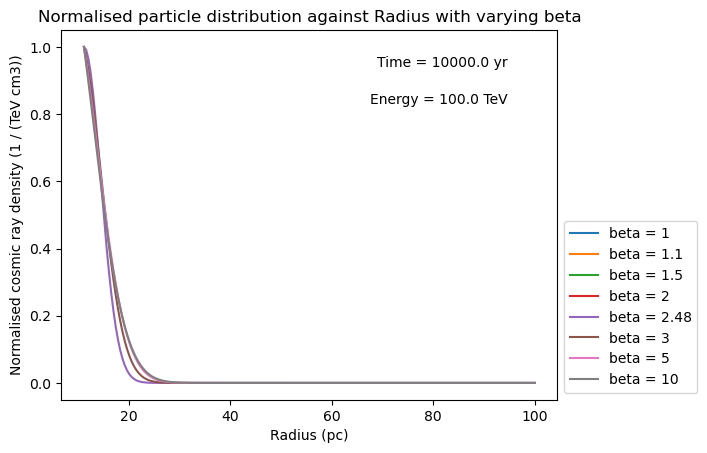

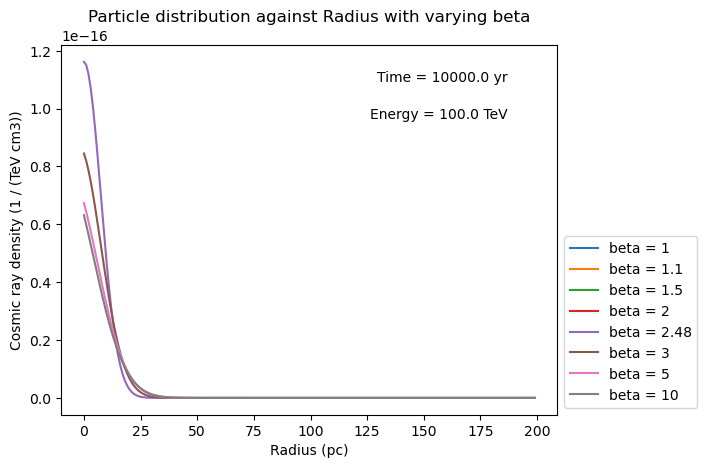

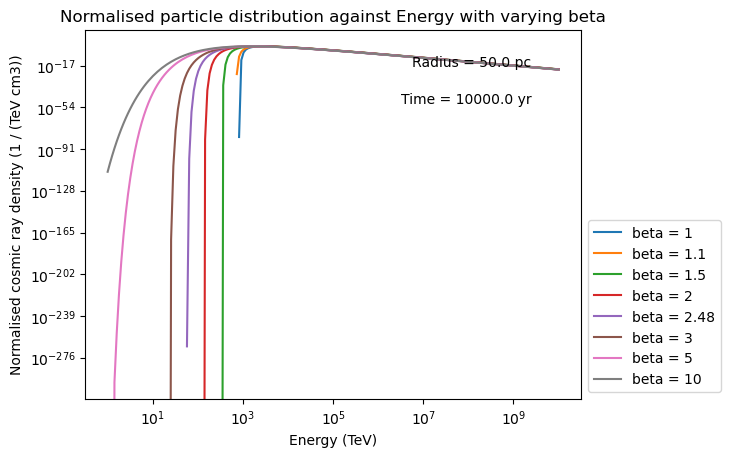

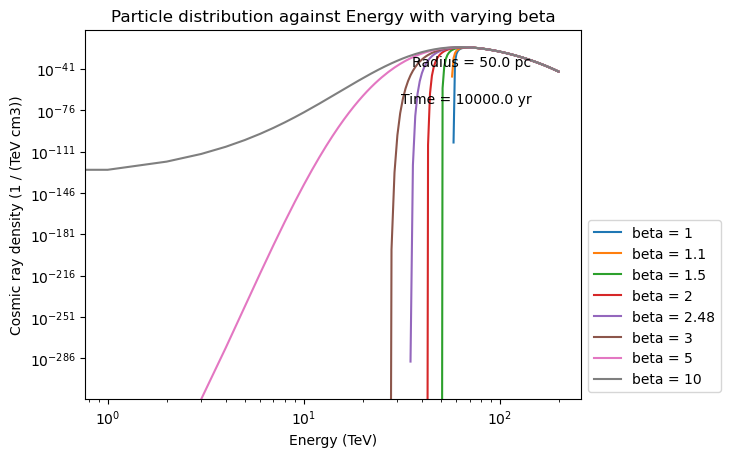

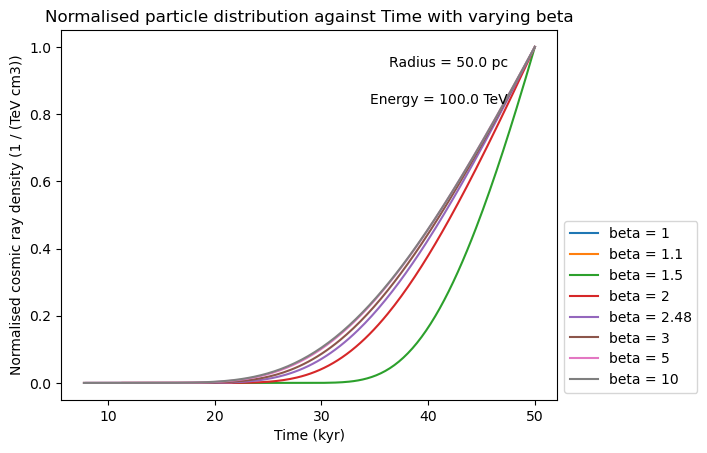

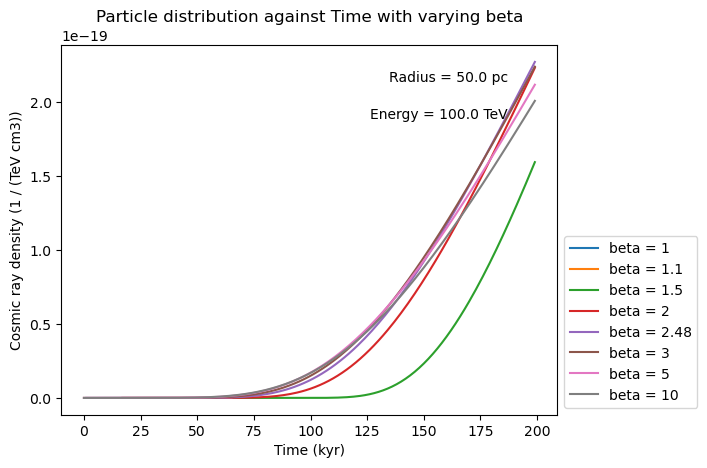

In [565]:
beta = 3
arr = [1, 1.1, 1.5, 2, 2.48, 3, 5, 10]

plotVar('R', beta, arr, 'beta')
plotVar('E', beta, arr, 'beta')
plotVar('t', beta, arr, 'beta')